<a href="https://colab.research.google.com/github/giovanimachado/phd-puc/blob/main/computacao-evolucionaria/EC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5 Knots = 9,26 km/h <br>
Poços em cluster economiza ~ 4 dias por poço <br>
Taxa diária ~ USD 0,57 MM/dia

## Optimizing P&A Sequence with Genetic Algortithms

In [2]:
pip install deap

     |████████████████████████████████| 163kB 12.0MB/s 


In [3]:
# pip install ipympl

In [4]:
import pandas as pd
import numpy as np
import random
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [5]:
import time
start = time.clock()

In [6]:
# np.random.seed(42)
# x = 1000 * np.random.random(size=10)
# y = 1000 * np.random.random(size=10)
# [print(x,",",y) for x,y in zip(x,y)]

In [7]:
#x

## Setting up wells information

In [8]:
well_table = pd.DataFrame.from_records([
    ['P1', 374.54011884736246 , 20.584494295802447, 'red'],
    ['P2', 950.7143064099162 , 969.9098521619943, 'red'],
    ['P3', 731.9939418114051 , 832.4426408004217, 'blue'],
    ['P4', 598.6584841970366 , 212.33911067827614, 'blue'],
    ['P5', 156.01864044243652 , 800.82496720710063, 'red'],
    ['P6', 155.99452033620264 , 183.4045098534338, 'red'],
    ['P7', 58.08361216819946 , 304.24224295953775, 'aqua'],
    ['P8', 866.1761457749352 , 524.7564316322379, 'aqua'],
    ['P9', 601.1150117432088 , 431.94501864211577, 'blue'],
    ['P10', 708.0725777960455 , 291.22914019804193, 'aqua'],   
])
well_table.columns = ['Poco', 'X', 'Y', 'Tool']

well_table

,Poco,X,Y,Tool
0,P1,374.540119,20.584494,red
1,P2,950.714306,969.909852,red
2,P3,731.993942,832.442641,blue
3,P4,598.658484,212.339111,blue
4,P5,156.018640,800.824967,red
5,P6,155.994520,183.404510,red
6,P7,58.083612,304.242243,aqua
7,P8,866.176146,524.756432,aqua
8,P9,601.115012,431.945019,blue
9,P10,708.072578,291.229140,aqua


In [9]:
# extract the information of wells in a format that is easier to use in the deap algorithms cost function
well_data = well_table[['X', 'Y', 'Tool', 'Poco']]
X = list(well_data['X'])
Y = list(well_data['Y'])
Tool = list(well_data['Tool'])
Poco = list(well_data['Poco'])

In [10]:
well_data.shape[0]

10

In [11]:
well_table = pd.read_csv('wells.csv', sep=";")
well_table.head()

,Poco,UTM norte,UTM leste,Tool
0,P36,7525580.90,392405.60,blue
1,P47,7525580.90,392405.60,blue
2,P66,7549400.00,402891.61,blue
3,P43,7515626.91,392567.60,blue
4,P53,7515626.91,392567.60,blue


In [12]:
# extract the information of wells in a format that is easier to use in the deap algorithms cost function
well_data = well_table[['UTM leste', 'UTM norte', 'Tool', 'Poco']]
X = list(well_data['UTM leste'])
Y = list(well_data['UTM norte'])
Tool = list(well_data['Tool'])
Poco = list(well_data['Poco'])

In [13]:
type(Poco[0])

str

In [14]:
# for i in range(len(X)-1):
#   print(x[i]-x[i+1])

In [15]:
# Y

## Define simulation parameters

In [16]:
cross_prob = .6            #60 a 65%
mutate_prob = .10          #5 a 10%
n_gen = 20000
rig_speed = 5 * 1852/1     #1Knot = 1852 m/h
dmm_tool = 96
pop_size = 400

## Define objective and support functions

In [17]:
# Função Objetivo
def objective_function_distance(individual):
  dist = 0
  #print(individual[0])
  for i in range(len(individual)-1):
    #print(individual[i], X[individual[i]], Y[individual[i]])
    dif_x = (X[individual[i]] - X[individual[i+1]])**2
    dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
    dist += np.sqrt(dif_x + dif_y)
  return (dist),

In [18]:
def distance(individual):
  dist = []
  #print(individual[0])
  for i in range(len(individual)-1):
    #print(individual[i], X[individual[i]], Y[individual[i]])
    dif_x = (X[individual[i]] - X[individual[i+1]])**2
    dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
    dist.append(np.sqrt(dif_x + dif_y))
  return (dist)

In [19]:
# # Função Objetivo
# def objective_function_distance(individual):
#   delta_tool = 0
#   dist = 0
#   #print(individual[0])
#   for i in range(len(individual)-1):
#     #print(individual[i], X[individual[i]], Y[individual[i]])
#     if (Tool[individual[i]]) == (Tool[individual[i+1]]):
#       dif_x = (X[individual[i]] - X[individual[i+1]])**2
#       dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
#       dist += np.sqrt(dif_x + dif_y)
#     else:
#       dif_x = (X[individual[i]] - X[individual[i+1]])**2
#       dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
#       dist += np.sqrt(dif_x + dif_y) + delta_tool
#   return (dist),

In [20]:
# Função Objetivo
def objective_function_time(individual):
  delta_tool = dmm_tool #h
  speed = rig_speed # m/h
  dist = 0
  time = 0
  #print(individual[0])
  for i in range(len(individual)-1):
    #print(individual[i], X[individual[i]], Y[individual[i]])
    if (Tool[individual[i]]) == (Tool[individual[i+1]]):
      dif_x = (X[individual[i]] - X[individual[i+1]])**2
      dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
      #dist += np.sqrt(dif_x + dif_y)
      time += np.sqrt(dif_x + dif_y)/speed
    else:
      dif_x = (X[individual[i]] - X[individual[i+1]])**2
      dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
      #dist += np.sqrt(dif_x + dif_y) + delta_tool
      #time += np.sqrt(dif_x + dif_y)/speed + delta_tool
      time += np.maximum(np.sqrt(dif_x + dif_y)/speed,delta_tool)
  return (time),

In [21]:
def time(individual):
  delta_tool = dmm_tool #h
  speed = rig_speed # m/h
  dist = 0
  time = []
  for i in range(len(individual)-1):
    if (Tool[individual[i]]) == (Tool[individual[i+1]]):
      dif_x = (X[individual[i]] - X[individual[i+1]])**2
      dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
      time.append(np.sqrt(dif_x + dif_y)/speed)
    else:
      dif_x = (X[individual[i]] - X[individual[i+1]])**2
      dif_y = (Y[individual[i]] - Y[individual[i+1]])**2
      time.append(np.maximum(np.sqrt(dif_x + dif_y)/speed,delta_tool))
  return (time)

In [22]:
def wells_sequence():
  seq = np.random.choice(well_data.shape[0], well_data.shape[0], replace=False)
  return seq.tolist()   

In [23]:
  # seq = np.random.choice(10, 10, replace=False)
  # seq = seq.tolist()
  # print(seq)

In [24]:
print(wells_sequence())

[23, 80, 111, 57, 46, 117, 1, 83, 16, 10, 24, 17, 20, 106, 98, 4, 104, 110, 15, 35, 121, 54, 91, 12, 92, 120, 87, 82, 36, 47, 123, 66, 14, 101, 7, 70, 113, 58, 96, 88, 94, 100, 5, 22, 105, 89, 19, 44, 51, 26, 62, 2, 53, 63, 81, 74, 42, 65, 103, 40, 86, 6, 60, 71, 78, 119, 49, 29, 55, 114, 27, 68, 112, 33, 59, 25, 95, 28, 108, 56, 8, 85, 0, 72, 13, 43, 50, 37, 34, 77, 21, 102, 48, 61, 38, 31, 76, 41, 69, 97, 52, 18, 99, 122, 3, 93, 90, 39, 64, 109, 32, 45, 116, 115, 84, 107, 67, 9, 30, 75, 79, 73, 11, 118]


In [25]:
#objective_function([9, 2, 3, 8, 5, 6, 7, 0, 4, 1])
# print(objective_function([9, 2, 3]))
# (np.sqrt((708.072578-731.993942)**2 + (291.229140-832.442641)**2)+
#  np.sqrt((731.993942-598.658484)**2 + (832.442641-212.339111)**2))

In [26]:
#print(objective_function([7, 8]))

In [27]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # função objetivo: nome, tipo(f.o.), peso de cada objetivo (no caso só um objetivo)
creator.create("Individual", list,  fitness=creator.FitnessMin)   # indivíduo

## Optimizing P&A sequence considering similarity and distance

In [28]:
toolbox = base.Toolbox()

toolbox.register("wells_sequence", wells_sequence)

#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.wells_sequence, n=1)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.wells_sequence)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", objective_function_time)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=0.05)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [29]:
print(toolbox.population(n=10))

[[59, 38, 26, 9, 103, 73, 42, 1, 39, 12, 76, 41, 111, 60, 100, 27, 114, 67, 109, 68, 115, 61, 64, 105, 40, 45, 112, 20, 58, 7, 70, 24, 94, 48, 4, 2, 44, 57, 47, 121, 32, 31, 123, 62, 120, 101, 83, 37, 5, 87, 52, 14, 43, 99, 75, 18, 108, 63, 74, 93, 53, 29, 28, 106, 25, 95, 21, 56, 22, 91, 79, 119, 17, 50, 35, 13, 23, 55, 113, 19, 71, 69, 80, 51, 97, 16, 107, 10, 77, 122, 84, 96, 11, 102, 54, 118, 65, 8, 33, 72, 49, 89, 78, 116, 98, 36, 92, 104, 46, 0, 66, 81, 86, 117, 15, 110, 30, 90, 88, 3, 34, 82, 6, 85], [95, 31, 12, 18, 42, 67, 68, 74, 122, 13, 51, 98, 83, 4, 86, 89, 28, 1, 94, 77, 106, 66, 22, 41, 84, 19, 33, 3, 45, 71, 50, 108, 97, 43, 27, 15, 93, 46, 36, 58, 82, 72, 6, 114, 56, 40, 35, 29, 60, 38, 88, 115, 10, 116, 121, 76, 91, 59, 104, 117, 44, 54, 25, 64, 11, 23, 39, 87, 55, 105, 49, 112, 118, 69, 103, 111, 2, 8, 100, 48, 80, 90, 61, 47, 0, 32, 123, 17, 62, 99, 20, 14, 5, 120, 52, 119, 9, 81, 65, 78, 107, 101, 92, 7, 70, 34, 37, 79, 85, 96, 110, 53, 113, 21, 26, 30, 109, 102, 

In [30]:
pop = toolbox.population(n=pop_size)                      # inicialização da pop
hof = tools.HallOfFame(1)                                 # melhor indivíduo
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [31]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_prob, mutpb=mutate_prob, ngen=n_gen, stats=stats, halloffame=hof, verbose=True)

'''
    population – A list of individuals.
    toolbox – A Toolbox that contains the evolution operators.
    cxpb – The probability of mating two individuals.
    mutpb – The probability of mutating an individual.
    ngen – The number of generation.
    stats – A Statistics object that is updated inplace, optional.
    halloffame – A HallOfFame object that will contain the best individuals, optional.
    verbose – Whether or not to log the statistics.
'''

A saída de streaming foi truncada nas últimas 5000 linhas.
15001	239   	4971.58	404.34 	4842.31	6922.41
15002	255   	4986.32	435.707	4842.31	7344.98
15003	268   	4969.36	419.006	4842.31	7748.87
15004	273   	4949.72	369.628	4842.31	7245.38
15005	246   	4943.28	355.046	4842.31	6852.82
15006	250   	4957.25	390.727	4842.31	7269.27
15007	249   	4979.26	453.426	4842.31	7954.7 
15008	252   	4952.01	362.676	4842.31	6796.97
15009	221   	4927.61	326.788	4842.31	7115.95
15010	244   	4979.36	437.327	4842.31	7396.83
15011	248   	5003.39	451.124	4842.31	7103.67
15012	248   	4977.26	423.827	4842.31	7053.05
15013	249   	4983.9 	417.296	4842.31	7152.41
15014	257   	4963.24	407.087	4842.31	7800.13
15015	237   	4962.08	403.055	4842.31	7249.33
15016	259   	4956.36	391.803	4842.31	7689   
15017	268   	4995.68	457.132	4842.31	7245.3 
15018	241   	4986.8 	454.197	4842.31	7363.52
15019	265   	4973.05	446.632	4842.31	7575.96
15020	225   	4984.11	463.417	4842.31	7455.59
15021	236   	4957.5 	383.826	4842.31	7191

'\n    population – A list of individuals.\n    toolbox – A Toolbox that contains the evolution operators.\n    cxpb – The probability of mating two individuals.\n    mutpb – The probability of mutating an individual.\n    ngen – The number of generation.\n    stats – A Statistics object that is updated inplace, optional.\n    halloffame – A HallOfFame object that will contain the best individuals, optional.\n    verbose – Whether or not to log the statistics.\n'

### Analysing evolutionary process

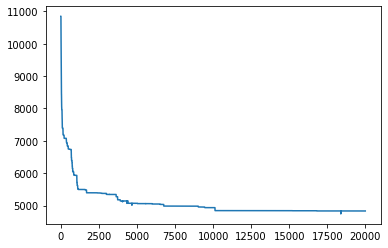

In [32]:
import matplotlib.pyplot as plt
gen, min = log.select('gen', 'min')
plt.plot(gen, min);

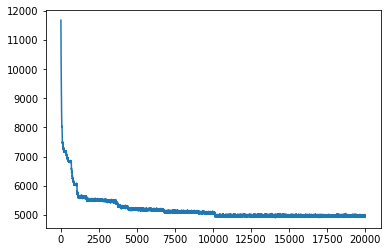

In [33]:
gen, avg = log.select('gen', 'avg')
plt.plot(gen, avg);

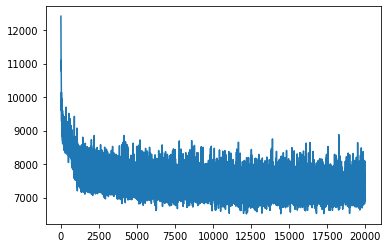

In [34]:
gen, maximum = log.select('gen', 'max')
plt.plot(gen, maximum);

### Optimization result

In [35]:
# Melhor solução
print("Otimizando a distância e semelhança entre poços - Melhor Indivíduo:")
print(hof[0])
print()
print("DMM/preparando para operar do melhor indivíduo: {number:.{digits}f} dias".format(
    number = (objective_function_time(hof[0])[0]/24), digits=2))
print()
print("Distância percorrida pelo melhor indivíduo: {number:.{digits}f} Km".format
      (number = (objective_function_distance(hof[0])[0]/1000), digits=2))
print()
total_t = time(hof[0])
print("Número de troca de ferramentas: {}".format(sum(i > 95.9 for i in total_t)))


Otimizando a distância e semelhança entre poços - Melhor Indivíduo:
[91, 90, 45, 16, 42, 121, 123, 122, 41, 40, 48, 96, 98, 110, 117, 116, 103, 102, 104, 105, 118, 58, 61, 59, 62, 66, 63, 36, 39, 7, 120, 12, 14, 13, 88, 87, 89, 18, 10, 9, 6, 4, 3, 5, 94, 53, 52, 80, 79, 74, 73, 81, 71, 70, 84, 57, 11, 21, 20, 23, 22, 25, 26, 92, 93, 64, 65, 111, 119, 107, 51, 50, 49, 112, 100, 101, 99, 95, 97, 29, 28, 30, 24, 27, 32, 31, 37, 33, 68, 75, 56, 55, 60, 17, 15, 46, 47, 2, 1, 0, 86, 85, 69, 78, 83, 77, 19, 8, 54, 82, 72, 76, 67, 34, 35, 38, 43, 44, 106, 115, 114, 109, 108, 113]

DMM/preparando para operar do melhor indivíduo: 197.60 dias

Distância percorrida pelo melhor indivíduo: 11668.46 Km

Número de troca de ferramentas: 46


In [36]:
total_d = distance(hof[0])
print(total_d)
print(sum(total_d))

[0.0, 8475.752745921756, 994702.5812877783, 290476.9118204926, 46337.12538095121, 52436.44096427598, 64965.12014773738, 78021.6319770357, 163685.28417014194, 293900.143791867, 54265.62642122632, 9109.206332057694, 51020.94560080203, 40777.27566280157, 17017.831745558073, 4096.321886766224, 0.0, 848.3575060665556, 0.0, 1126.7225214754442, 43881.95181917298, 1915.295580347855, 3743.509118514785, 78.78540600878983, 70502.12511385717, 64605.13174700668, 1243189.8789518748, 3670.5135907677736, 1234868.6733528583, 31717.174770589212, 84024.82799668533, 14627.498317901825, 17349.401661152468, 1262592.7715728334, 0.0, 685.8403677241438, 5453.531040527797, 1198196.855895354, 5164.768122597783, 71825.47961837746, 5287.73609781146, 0.0, 9360.859684884494, 284656.3642464366, 321702.4506413754, 0.0, 69260.51943630303, 0.0, 4516.118355402125, 7078.862242769383, 33346.807917072045, 7692.019775078357, 45316.027286911354, 16241.339130139679, 16021.81884738753, 57686.084925222654, 40136.18292115163, 413

In [37]:
total_t = time(hof[0])
print(total_t)
print(sum(total_t))

[0.0, 96.0, 107.41928523626116, 96.0, 96.0, 5.662682609533043, 7.01567172221786, 96.0, 17.676596562650317, 96.0, 96.0, 0.9837155866153018, 96.0, 4.403593484103841, 1.8377788062157745, 0.44236737438080176, 0.0, 0.09161528143267339, 0.0, 0.12167629821549074, 96.0, 0.20683537584750056, 0.4042666434681193, 0.008508143197493503, 96.0, 6.976796084989922, 134.25376662547245, 0.39638375710235135, 133.35514831024386, 96.0, 96.0, 1.5796434468576486, 1.8735854925650612, 136.34911140095394, 0.0, 0.07406483452744533, 96.0, 129.39490884399072, 0.5577503372135835, 96.0, 0.5710298161783435, 0.0, 1.0108919746095566, 96.0, 96.0, 0.0, 96.0, 0.0, 0.4877017662421302, 0.7644559657418339, 3.601167161670847, 0.8306716819739046, 4.8937394478306, 1.7539243121101165, 96.0, 96.0, 96.0, 4.465455630810321, 0.7079201313204381, 0.6026942102382858, 96.0, 2.506911107023548, 96.0, 29.902241243394077, 96.0, 0.2585842727688865, 96.0, 0.7654513115872019, 0.5837473134014998, 96.0, 0.0, 0.12158215868286015, 96.0, 0.553714953

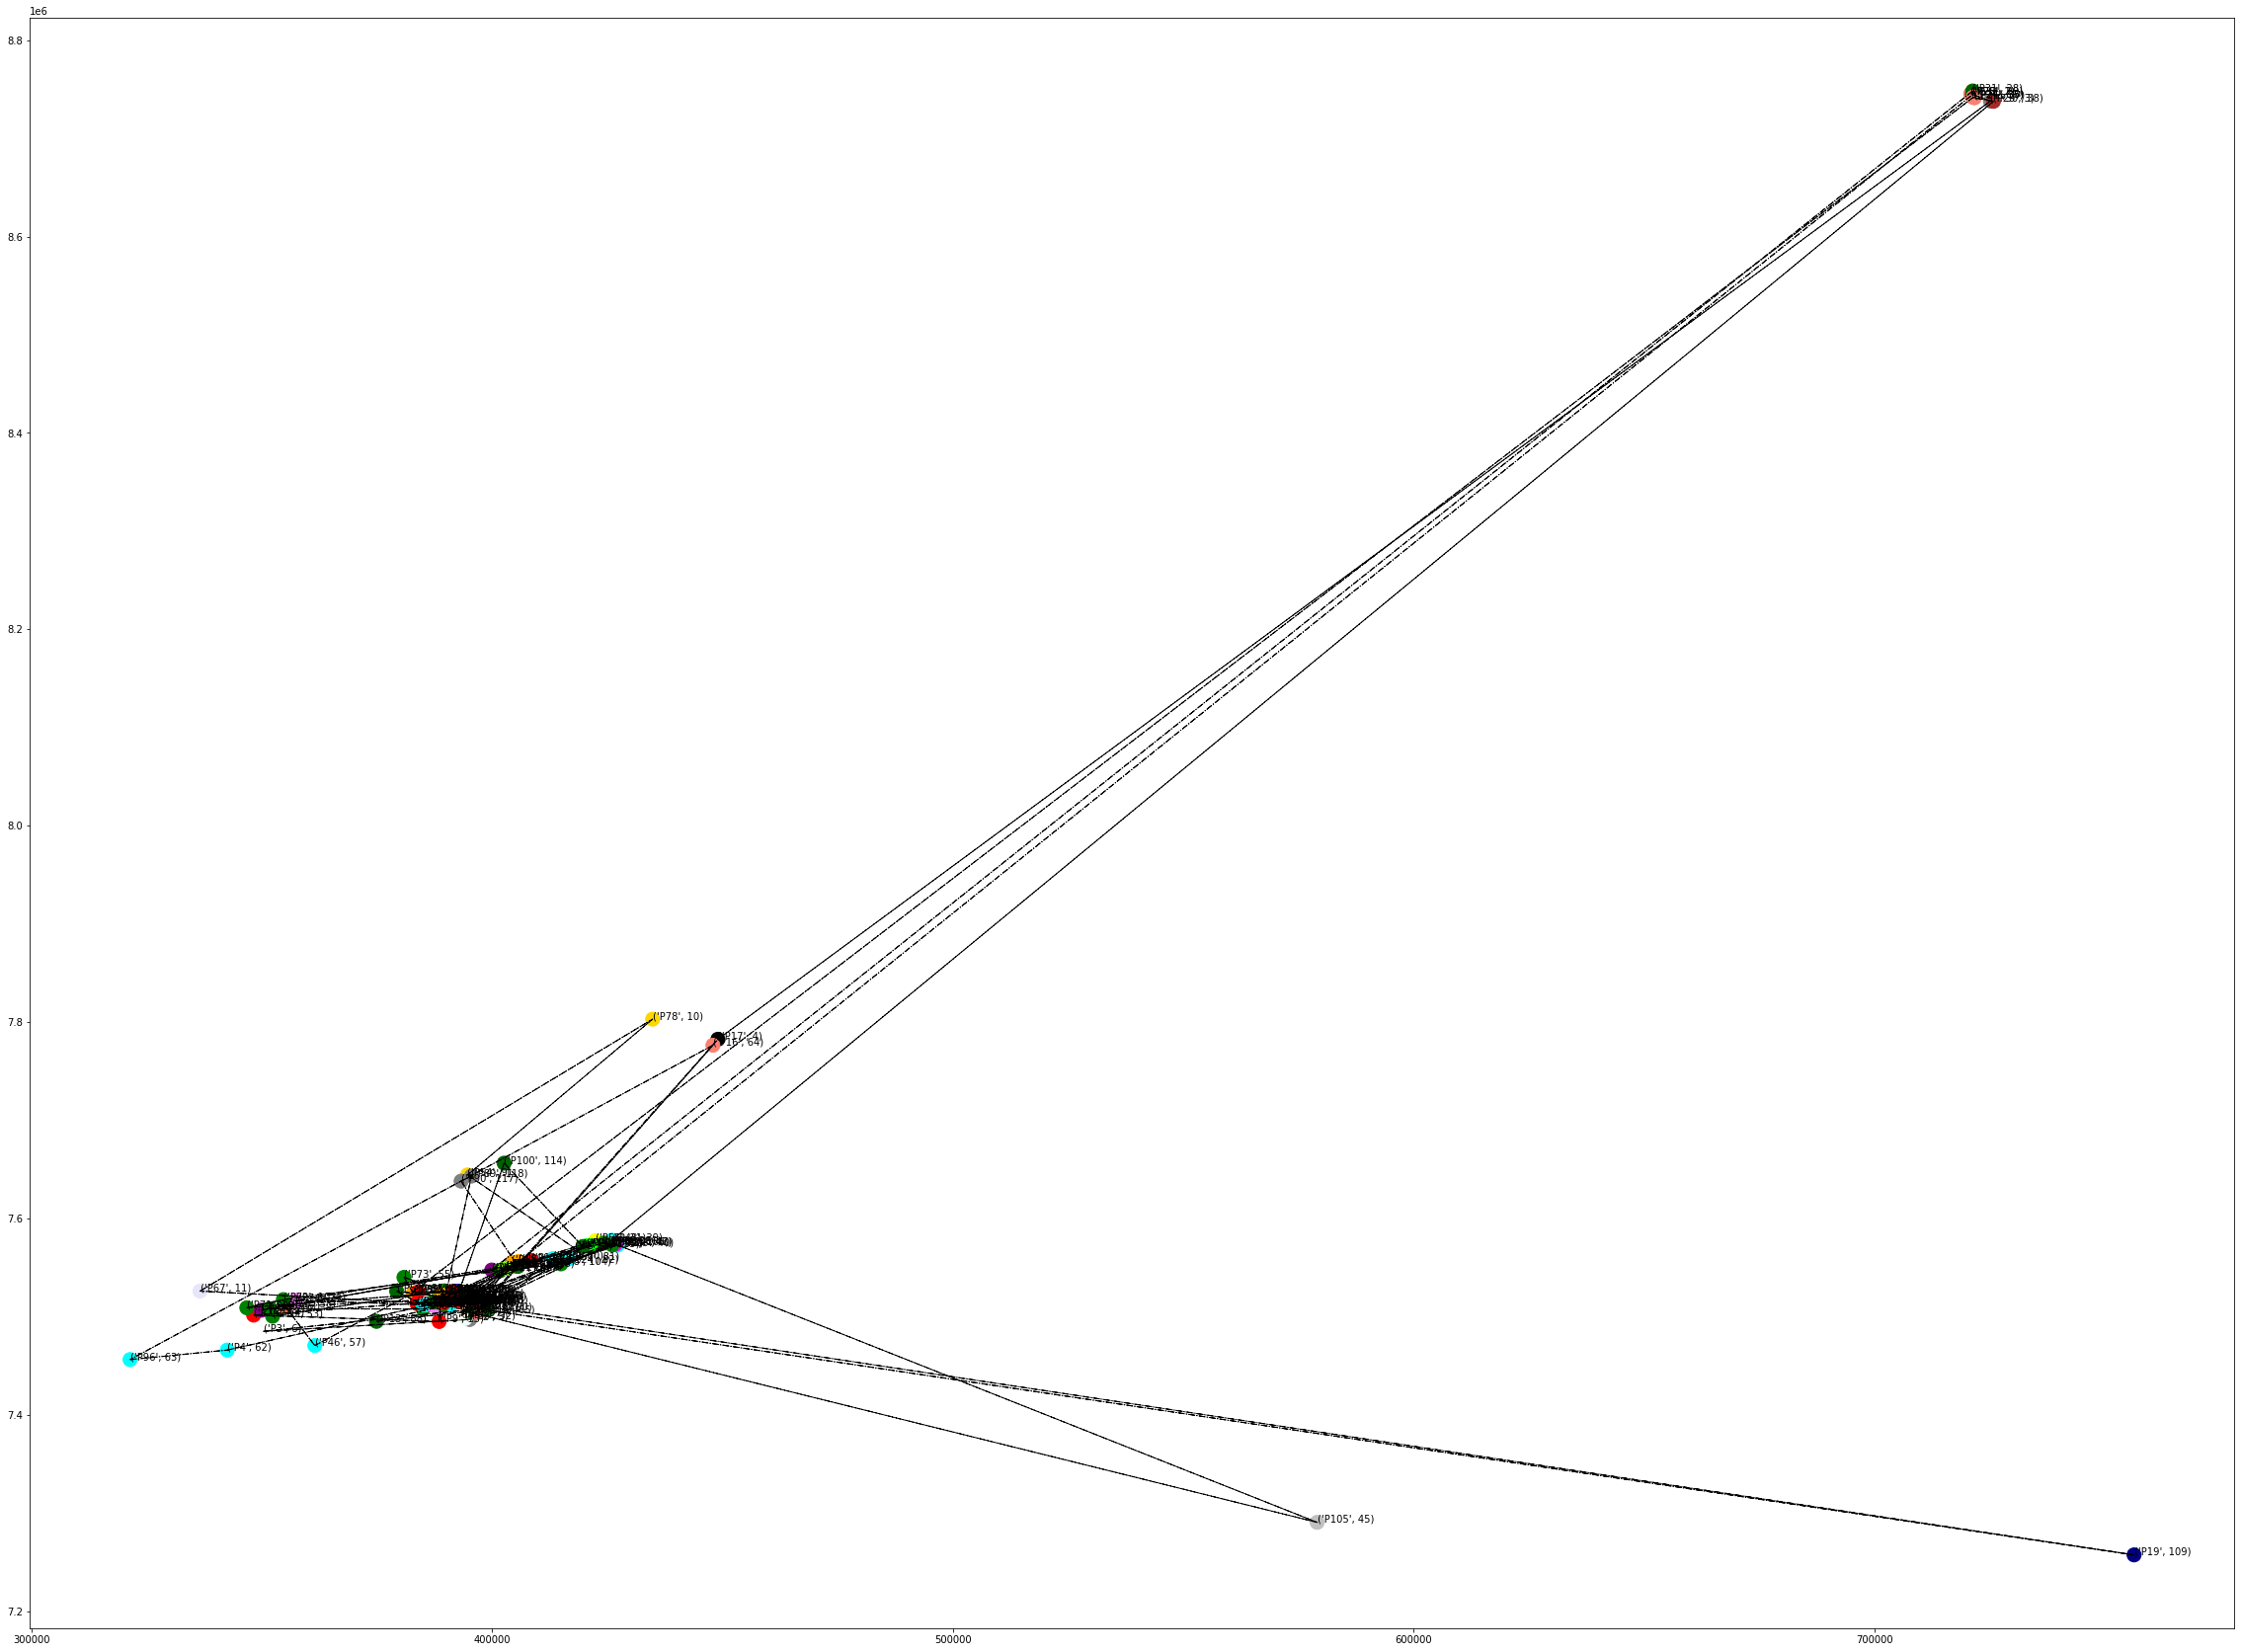

In [38]:
x = [X[i] for i in hof[0]]
y = [Y[i] for i in hof[0]]
tool = [Tool[i] for i in hof[0]]

fig, ax = plt.subplots(figsize=(40,30))
ax.scatter(x, y, c=tool, s=200)
# ax.set_ylim([7.4e6, 7.6e6])
# ax.set_xlim([3.75e5, 4.25e5])

for i, well in enumerate(hof[0]):
  ax.annotate((Poco[well],i+1), (X[well], Y[well]))
  # print(Poco[well],i+1)

for i, well in enumerate(hof[0]):
    if i != (len(hof[0])-1):
      # print(i, well)
      dx= X[hof[0][((i + 1) % len(hof[0]))]] - X[well] 
      dy= Y[hof[0][((i + 1) % len(hof[0]))]] - Y[well] 
      ax.arrow(X[well],Y[well], dx , dy, head_width=10, head_length=20, 
              fc='lightblue', ec='black', length_includes_head='True', width=0.1,
              linestyle="-.")

In [39]:
#well_table(hof[0])
opt_well_table = well_table.reindex(hof[0])

In [40]:
opt_well_table

,Poco,UTM norte,UTM leste,Tool
91,P28,8745365.00,720905.10,salmon
90,P25,8745365.00,720905.10,salmon
45,P29,8738030.00,725152.00,grey
16,P17,7782423.90,449017.60,black
42,P2,7496986.00,395147.00,grey
...,...,...,...,...
115,P49,7515462.99,392707.99,red
114,P37,7515462.99,392707.99,red
109,P44,7525552.90,391584.60,red
108,P34,7525552.90,391584.60,red


## Optimizing P&A Sequence considering only distance

In [41]:
toolbox = base.Toolbox()

toolbox.register("wells_sequence", wells_sequence)

#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.wells_sequence, n=1)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.wells_sequence)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", objective_function_distance)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=0.05)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [42]:
pop = toolbox.population(n=pop_size)                      # inicialização da pop
hof_dist = tools.HallOfFame(1)                            # melhor indivíduo
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [43]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_prob, mutpb=mutate_prob, ngen=n_gen, stats=stats, halloffame=hof_dist, verbose=True)
'''
    population – A list of individuals.
    toolbox – A Toolbox that contains the evolution operators.
    cxpb – The probability of mating two individuals.
    mutpb – The probability of mutating an individual.
    ngen – The number of generation.
    stats – A Statistics object that is updated inplace, optional.
    halloffame – A HallOfFame object that will contain the best individuals, optional.
    verbose – Whether or not to log the statistics.
'''

A saída de streaming foi truncada nas últimas 5000 linhas.
15001	225   	4.3869e+06 	1.10341e+06	4.156e+06  	1.27508e+07
15002	268   	4.54341e+06	1.57491e+06	4.156e+06  	1.76956e+07
15003	230   	4.61522e+06	1.94538e+06	4.156e+06  	2.29778e+07
15004	278   	4.61695e+06	1.80038e+06	4.156e+06  	1.73459e+07
15005	287   	4.69549e+06	2.02064e+06	4.156e+06  	1.90959e+07
15006	270   	4.7497e+06 	2.05733e+06	4.156e+06  	1.88128e+07
15007	262   	4.51295e+06	1.69198e+06	4.156e+06  	2.03767e+07
15008	244   	4.56468e+06	1.74225e+06	4.156e+06  	1.66253e+07
15009	257   	4.67428e+06	1.92206e+06	4.156e+06  	1.64211e+07
15010	252   	4.68673e+06	1.85954e+06	4.156e+06  	1.85575e+07
15011	254   	4.58522e+06	1.60657e+06	4.156e+06  	1.57197e+07
15012	266   	4.54206e+06	1.67242e+06	4.156e+06  	1.77801e+07
15013	256   	4.51231e+06	1.49055e+06	4.156e+06  	1.74122e+07
15014	246   	4.55166e+06	1.65949e+06	4.156e+06  	1.77107e+07
15015	256   	4.69664e+06	2.08933e+06	4.156e+06  	1.94647e+07
15016	250   	4.64174e+06	1

'\n    population – A list of individuals.\n    toolbox – A Toolbox that contains the evolution operators.\n    cxpb – The probability of mating two individuals.\n    mutpb – The probability of mutating an individual.\n    ngen – The number of generation.\n    stats – A Statistics object that is updated inplace, optional.\n    halloffame – A HallOfFame object that will contain the best individuals, optional.\n    verbose – Whether or not to log the statistics.\n'

### Analysing evolutionary process

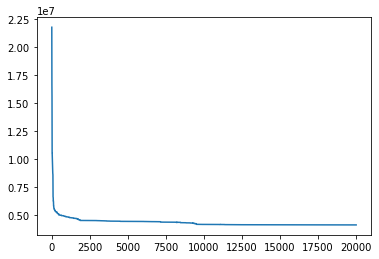

In [44]:
import matplotlib.pyplot as plt
gen, min = log.select('gen', 'min')
plt.plot(gen, min);

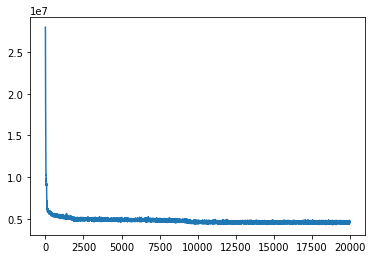

In [45]:
gen, avg = log.select('gen', 'avg')
plt.plot(gen, avg);

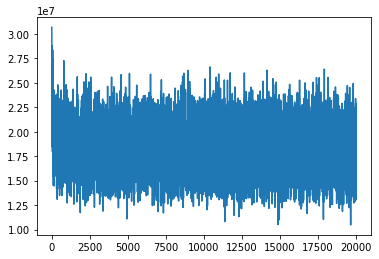

In [46]:
gen, maximum = log.select('gen', 'max')
plt.plot(gen, maximum);

### Optimization result

In [47]:
# Melhor solução
print("Otimizando a distância e semelhança entre poços - Melhor Indivíduo:")
print(hof_dist[0])
print()
print("DMM/preparando para operar do melhor indivíduo: {number:.{digits}f} dias".format(
    number = (objective_function_time(hof_dist[0])[0]/24), digits=2))
print()
print("Distância percorrida pelo melhor indivíduo: {number:.{digits}f} Km".format
      (number = (objective_function_distance(hof_dist[0])[0]/1000), digits=2))
print()
total_t = time(hof_dist[0])
print("Número de troca de ferramentas: {}".format(sum(i > 95.9 for i in total_t)))

Otimizando a distância e semelhança entre poços - Melhor Indivíduo:
[54, 94, 75, 123, 79, 80, 4, 3, 115, 114, 68, 31, 96, 6, 99, 95, 27, 76, 23, 112, 64, 65, 7, 61, 41, 34, 92, 16, 18, 45, 89, 90, 91, 36, 39, 87, 88, 40, 0, 67, 15, 55, 100, 59, 60, 62, 2, 19, 63, 85, 97, 32, 13, 84, 43, 44, 48, 110, 71, 66, 86, 73, 116, 119, 22, 106, 103, 105, 104, 118, 8, 14, 20, 1, 109, 108, 107, 21, 81, 117, 42, 12, 47, 37, 82, 72, 121, 25, 26, 11, 33, 74, 102, 17, 58, 101, 122, 35, 49, 51, 50, 52, 53, 10, 120, 29, 113, 57, 56, 70, 69, 38, 78, 28, 77, 46, 83, 9, 30, 98, 111, 24, 5, 93]

DMM/preparando para operar do melhor indivíduo: 385.48 dias

Distância percorrida pelo melhor indivíduo: 4145.56 Km

Número de troca de ferramentas: 96


In [48]:
total_d = distance(hof_dist[0])
print(total_d)
print(sum(total_d))

[180344.7758220909, 281740.61386495206, 1878.6553702049773, 5481.0802767337755, 0.0, 3551.2701305446512, 0.0, 215.82196018936418, 0.0, 1846.0159859004887, 1475.5379934108987, 6397.306493360834, 829.6222031744329, 1693.7957373898423, 2187.486457100935, 558.3929262625488, 3825.000423542635, 5230.377465938631, 29826.238846629778, 2830.17855798854, 2394.4903658398894, 81.05553651663777, 3784.5912038424563, 89876.64540557886, 14370.303754841141, 128360.75127838911, 6206.6854278269975, 994619.232842684, 709.8535060137408, 4783.6190912320935, 4113.626259153838, 0.0, 2984.7467061719635, 3670.5135907677736, 2689.823720989167, 0.0, 981816.0148965585, 280559.6434874588, 793.4595137749626, 4272.182112223214, 3490.4349969737395, 29844.695362494283, 98.2432705072734, 0.0, 78.78540600878983, 2350.0054068235772, 35.53280878271693, 3536.0644971634993, 54362.9611113866, 2763.8388231223817, 23892.40483919524, 3680.9765008758204, 14478.711684348924, 98785.99937815515, 5607.291026957886, 131117.83776687257

In [49]:
print(total_t)
print(sum(total_t))

[96.0, 96.0, 96.0, 96.0, 0.0, 96.0, 0.0, 96.0, 0.0, 96.0, 96.0, 96.0, 96.0, 96.0, 0.23622963899578128, 96.0, 96.0, 96.0, 96.0, 96.0, 0.2585842727688865, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 107.41028432426393, 96.0, 96.0, 0.44423609710084644, 0.0, 96.0, 0.39638375710235135, 96.0, 0.0, 106.02764739703656, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 0.0, 0.008508143197493503, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 0.6055389877924283, 96.0, 96.0, 96.0, 96.0, 96.0, 4.131184344857341, 96.0, 0.1457519100959647, 96.0, 96.0, 0.26414099621022175, 0.09161528143267339, 0.0, 0.12167629821549074, 96.0, 96.0, 96.0, 96.0, 96.0, 0.0, 1.5746662045353663, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 0.025010801467486177, 96.0, 96.0, 2.506911107023548, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 0.12158215868286015, 0.0, 96.0, 0.0, 96.0, 96.0, 96.0, 96.0, 96.0, 0.6548784969817703, 96.0, 2.5783503550331393, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96

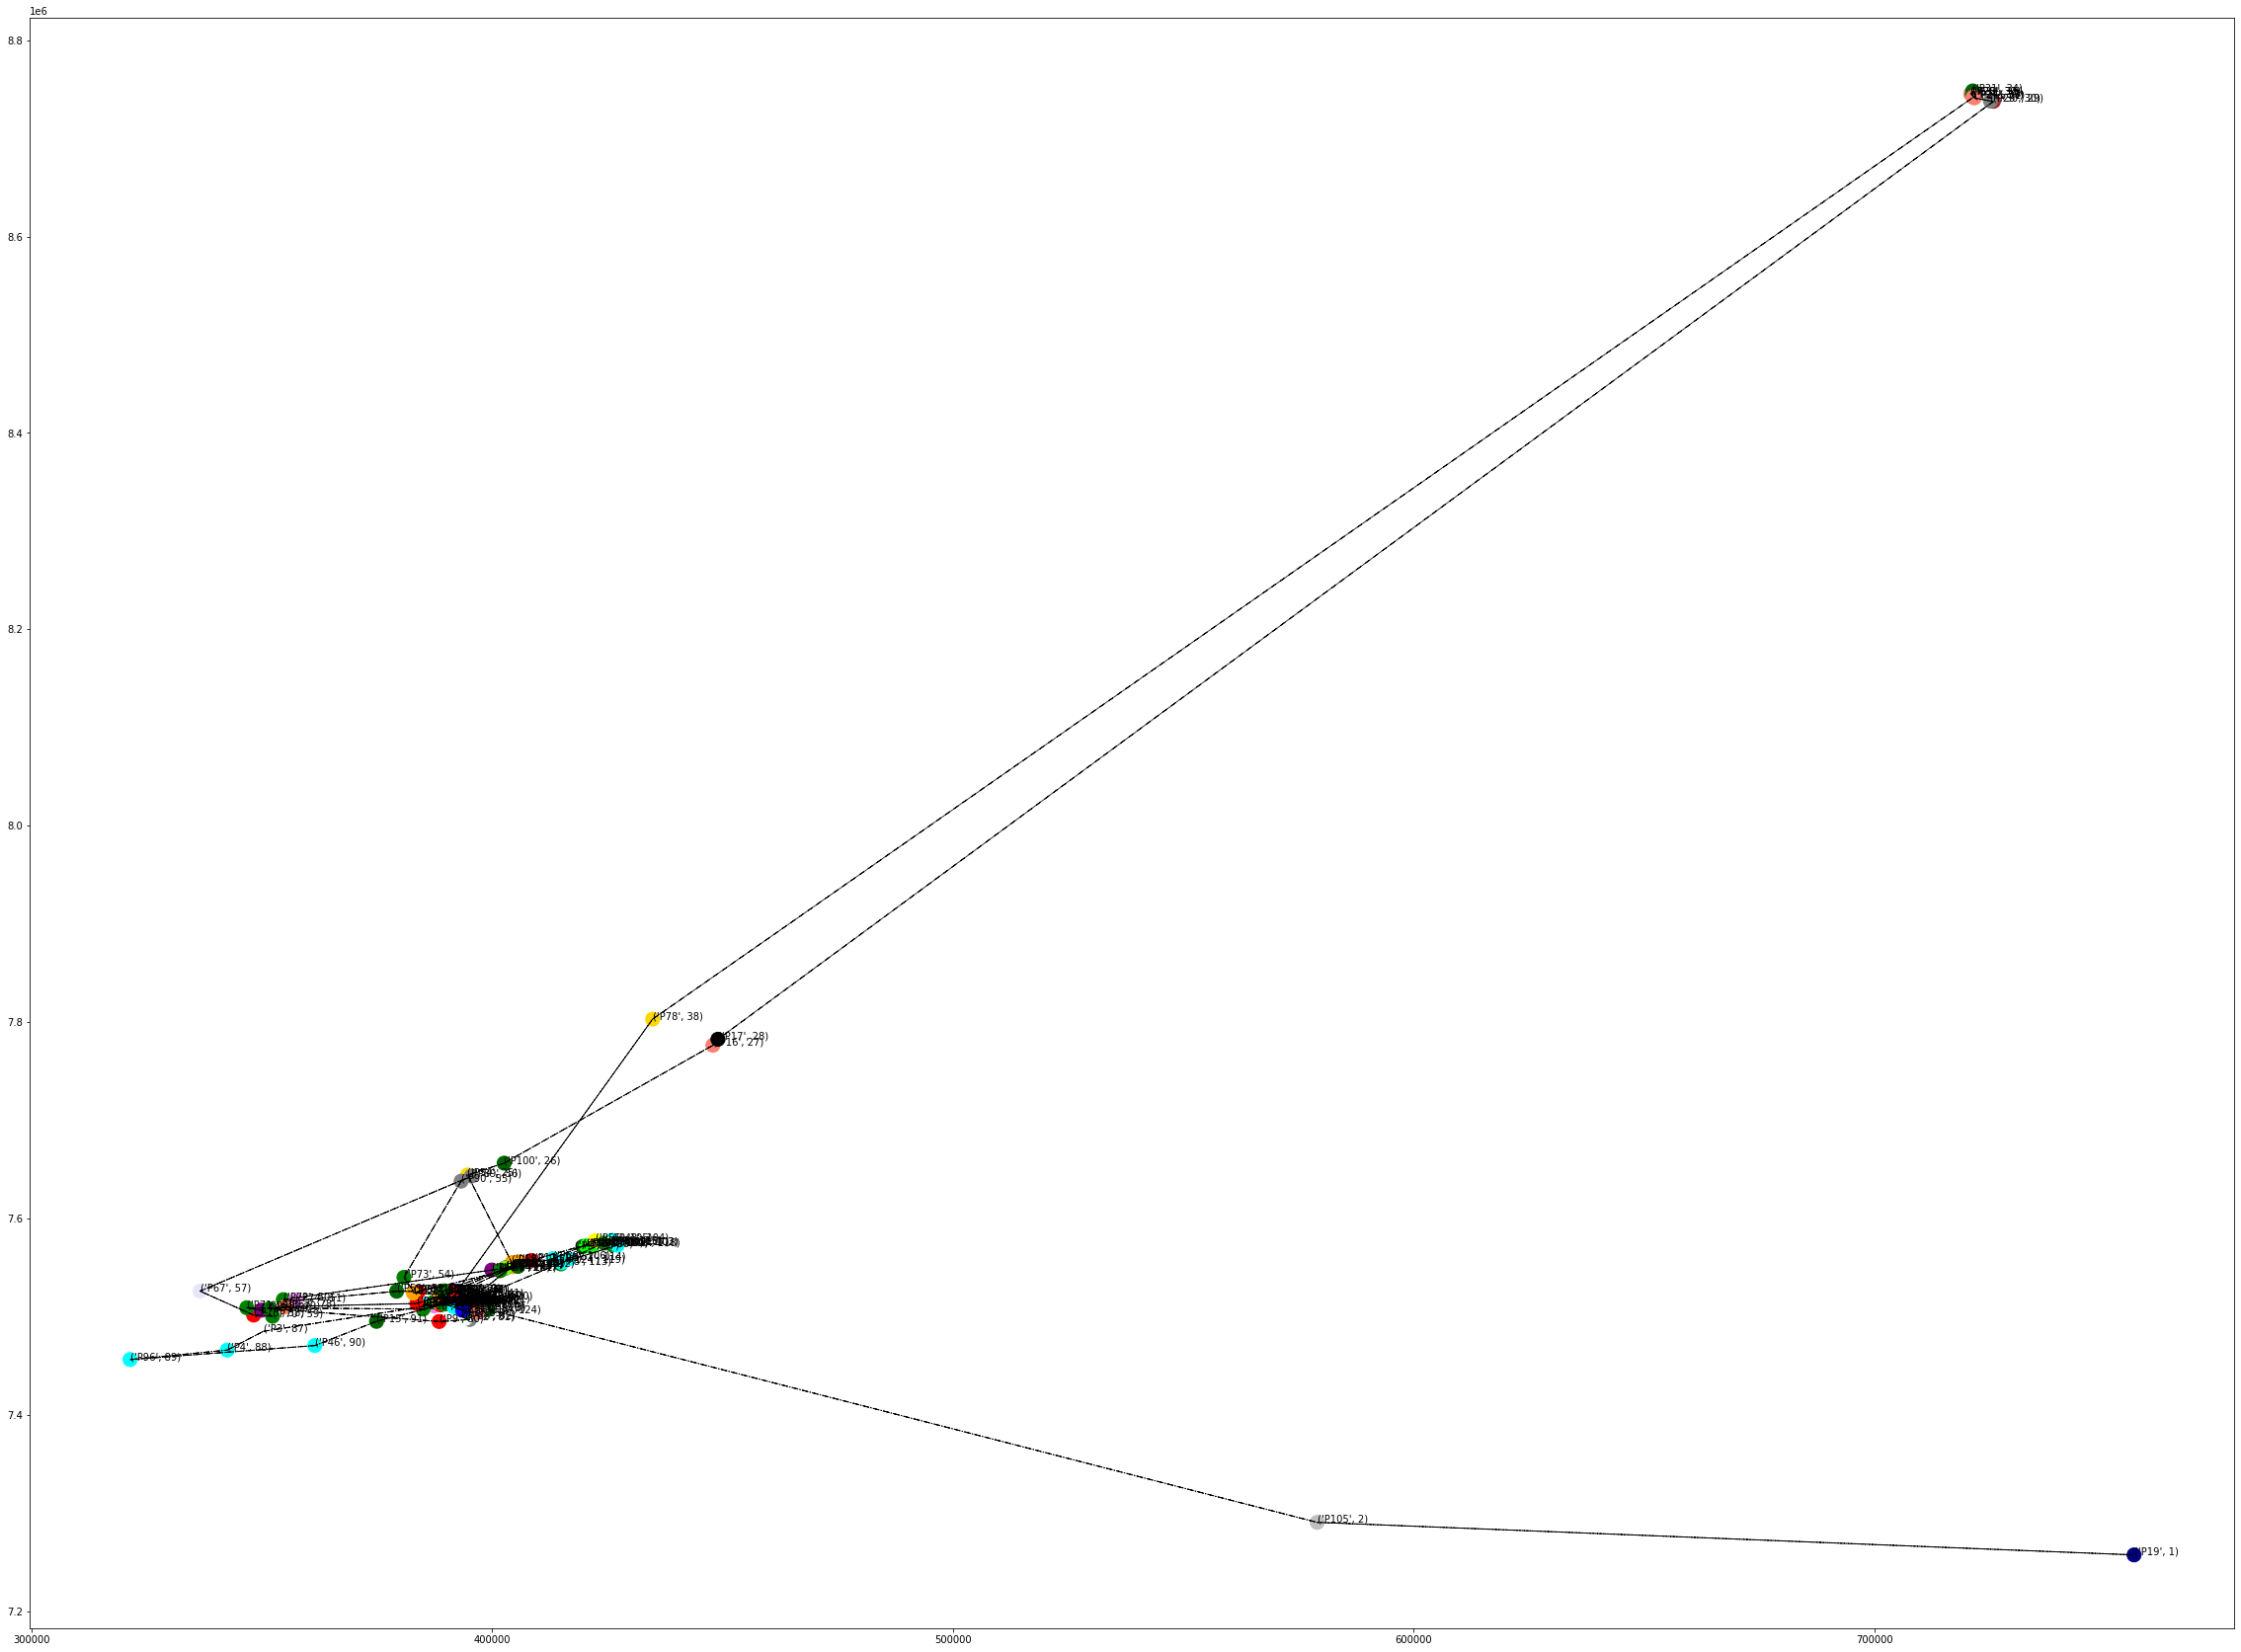

In [50]:
x = [X[i] for i in hof_dist[0]]
y = [Y[i] for i in hof_dist[0]]
tool = [Tool[i] for i in hof_dist[0]]

fig, ax = plt.subplots(figsize=(40,30))
ax.scatter(x, y, c=tool, s=200)
# ax.set_ylim([7.4e6, 7.6e6])
# ax.set_xlim([3.0e5, 5.0e5])


for i, well in enumerate(hof_dist[0]):
  ax.annotate((Poco[well],i+1), (X[well], Y[well]))
  # print(Poco[well],i+1)

for i, well in enumerate(hof_dist[0]):
    if i != (len(hof[0])-1):
      # print(i, well)
      dx= X[hof_dist[0][((i + 1) % len(hof_dist[0]))]] - X[well] 
      dy= Y[hof_dist[0][((i + 1) % len(hof_dist[0]))]] - Y[well] 
      ax.arrow(X[well],Y[well], dx , dy, head_width=10, head_length=20, 
              fc='lightblue', ec='black', length_includes_head='True', width=0.1,
              linestyle="-.")

In [51]:
#well_table(hof[0])
opt_dist_well_table = well_table.reindex(hof_dist[0])

In [52]:
opt_dist_well_table

,Poco,UTM norte,UTM leste,Tool
54,P19,7257201.99,756326.99,navy
94,P105,7290359.90,579056.60,silver
75,P7,7507164.90,399130.60,green
123,P10,7508053.90,397475.60,white
79,P97,7512549.90,394340.60,green
...,...,...,...,...
98,P87,7518188.90,396470.60,violet
111,P22,7515288.90,395891.60,red
24,P121,7509897.91,391749.61,cyan
5,P120,7506324.90,393615.60,blue


In [53]:
end = time.clock()

AttributeError: ignored

In [ ]:
print("Time elapsed during the calculation: {number:.{digits}f} seconds".format
      (number = (end - star), digits=2)) 